In [1]:
from sklearn.datasets import fetch_openml

# Load the MNIST dataset
mnist = fetch_openml('mnist_784', version=1)

# Print the keys of the dataset dictionary
print(list(mnist.keys()))


['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url']


In [2]:
>>> X, y = mnist["data"], mnist["target"]
>>> X.shape

(70000, 784)

In [3]:
>>> y.shape

(70000,)

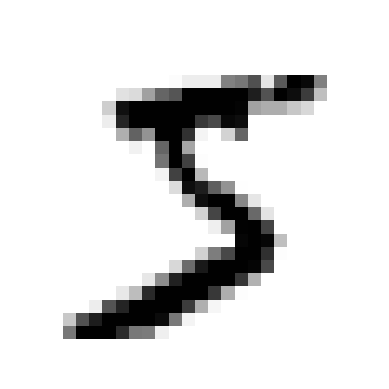

In [4]:
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import numpy as np

# Load MNIST
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist["data"], mnist["target"].astype(int)

# Access the first digit
some_digit = X.iloc[0]                   # get first row (as Series)
some_digit_image = some_digit.to_numpy().reshape(28, 28)  # convert to array and reshape

# Plot the digit
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()


In [5]:
>>> y[0]

np.int64(5)

In [6]:
>>> y = y.astype(np.uint8)

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [8]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

In [9]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

,loss,'hinge'
,penalty,'l2'
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,1000
,tol,0.001
,shuffle,True
,verbose,0
,epsilon,0.1
,n_jobs,None


In [10]:
>>> sgd_clf.predict([some_digit])

I:\Python\%ML_PATH%\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)

    # Use .iloc for row-based access
    X_train_folds = X_train.iloc[train_index]
    y_train_folds = y_train_5.iloc[train_index]
    X_test_fold = X_train.iloc[test_index]
    y_test_fold = y_train_5.iloc[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))


0.9669
0.91625
0.96785


In [12]:
>>> from sklearn.model_selection import cross_val_score
>>> cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [13]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
 def fit(self, X, y=None):
  return self
 def predict(self, X):
  return np.zeros((len(X), 1), dtype=bool)

In [14]:
>>> never_5_clf = Never5Classifier()
>>> cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

In [15]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [16]:
>>> from sklearn.metrics import confusion_matrix
>>> confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [17]:
>>> y_train_perfect_predictions = y_train_5
>>> confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

In [18]:
>>> from sklearn.metrics import precision_score, recall_score
>>> precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [19]:
>>> recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [20]:
>>> from sklearn.metrics import f1_score
>>> f1_score(y_train_5, y_train_pred)

0.7325171197343847

In [21]:
>>> y_scores = sgd_clf.decision_function([some_digit])
>>> y_scores

I:\Python\%ML_PATH%\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([2164.22030239])

In [22]:
>>> threshold = 0
>>> y_some_digit_pred = (y_scores > threshold)

In [23]:
>>> threshold = 8000
>>> y_some_digit_pred = (y_scores > threshold)
>>> y_some_digit_pred

array([False])

In [24]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
method="decision_function")

In [25]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

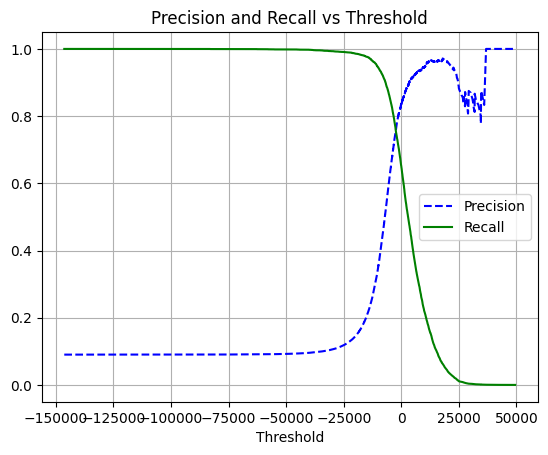

In [26]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="best")
    plt.grid(True)
    plt.title("Precision and Recall vs Threshold")
    plt.show()
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [27]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [28]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [29]:
>>> precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [30]:
>>> recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

In [31]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [32]:
import matplotlib.pyplot as plt

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.grid(True)
    if label:
        plt.legend(loc="lower right")

# Example usage (outside the function):
# plot_roc_curve(fpr, tpr, label="SGD Classifier")
# plt.show()


In [33]:
>>> from sklearn.metrics import roc_auc_score
>>> roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [34]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
method="predict_proba")

In [35]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

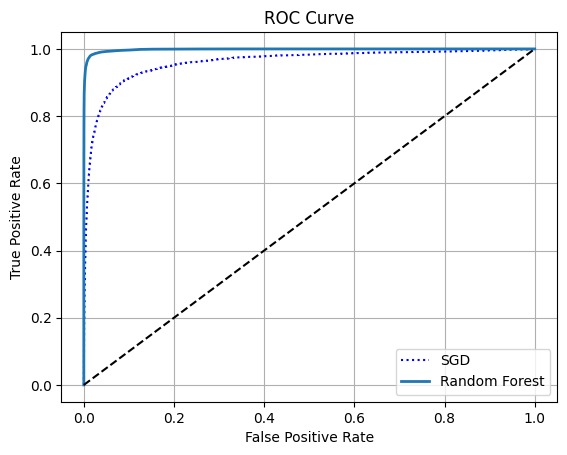

In [36]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [37]:
>>> roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [ ]:
>>> from sklearn.svm import SVC
>>> svm_clf = SVC()
>>> svm_clf.fit(X_train, y_train) # y_train, not y_train_5
>>> svm_clf.predict([some_digit])

In [ ]:
>>> some_digit_scores = svm_clf.decision_function([some_digit])
>>> some_digit_scores

In [ ]:
>>> np.argmax(some_digit_scores)

In [ ]:
>>> svm_clf.classes_

In [ ]:
>>> svm_clf.classes_[5]

In [ ]:
>>> from sklearn.multiclass import OneVsRestClassifier
>>> ovr_clf = OneVsRestClassifier(SVC())
>>> ovr_clf.fit(X_train, y_train)

In [ ]:
>>> ovr_clf.predict([some_digit])

In [ ]:
>>> len(ovr_clf.estimators_)

In [ ]:
>>> sgd_clf.fit(X_train, y_train)
>>> sgd_clf.predict([some_digit])

In [ ]:
>>> sgd_clf.decision_function([some_digit])

In [ ]:
>>> cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

In [ ]:
>>> from sklearn.preprocessing import StandardScaler
>>> scaler = StandardScaler()
>>> X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
>>> cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

In [ ]:
>>> y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
>>> conf_mx = confusion_matrix(y_train, y_train_pred)
>>> conf_mx

In [ ]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

In [ ]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [ ]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

In [ ]:
>>> knn_clf.predict([some_digit])

In [ ]:
>>> y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
>>> f1_score(y_multilabel, y_train_knn_pred, average="macro")

In [ ]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [ ]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)